# Convolutional Neural Networks with Intermediate Loss for 3D Super-Resolution of CT and MRI Scans

This notebook is a replication/exploration of the paper listed above. Data was tested on the ABIDEII-BNI1 anatomical scans (subjects 29006 - 29011 for training, 29012 - 29015 for testing)

In [173]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import sys
sys.path.append('..') # Stupid thing Python makes you do to import from a sibling directory
from gen_utils.SrGen import SrGen # Custom class for image generation

## Define model

In [174]:
class CNNIL(nn.Module):
    def __init__(self, upscale=2, axs = 'hw'):
        super().__init__()
        self.axs = axs

        self.rel = nn.ReLU()
        if axs == 'hw':
            self.conv1 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv2 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv3 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv4 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv5 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv6 = nn.Conv2d(32,4,3, padding='same', bias=False)
            
            # Upscale step occurs here

            self.conv7 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv8 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv9 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv10 = nn.Conv2d(32,1,3, padding='same', bias = False)
        elif axs == 'h' or axs == 'w':
            self.conv1 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv2 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv3 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv4 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv5 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv6 = nn.Conv2d(32,2,3, padding='same', bias=False)
            
            # Upscale step occurs here

            self.conv7 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv8 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv9 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv10 = nn.Conv2d(32,1,3, padding='same', bias = False)

    def forward(self, x):

        x = self.rel(self.conv1(x))
        
        x_l = self.rel(self.conv2(x))
        x_l = self.rel(self.conv3(x_l))
        x_l = self.rel(self.conv4(x_l+x))
        x_l = self.rel(self.conv5(x_l))
        x_l = self.rel(self.conv6(x_l+x))

        x_l = self.kern_upscale(x_l, axs = self.axs)

        x = self.rel(self.conv7(x_l))
        x_h = self.rel(self.conv8(x))
        x_h = self.rel(self.conv9(x_h))
        x_h = self.rel(self.conv10(x_h+x))

        return x_l, x_h #Return both results for the loss function

    @staticmethod
    def kern_upscale(x, axs='hw'):
        # Function to do the unique upscaling pattern they propose in
        # the paper
        #TODO: have them input a tuple for scale of the dimensions they wish to expand along
        s, c, h, w = [int(_) for _ in list(x.shape)]

        if axs == 'hw':
            c = int(c/2)

            b = torch.cat(torch.unbind(x,1),2)
            b = torch.reshape(b,(s,1,h*c,w*c))
            b = torch.transpose(b,2,3)
            b = torch.cat(torch.split(b,h,2),3)
            b = torch.reshape(b,(s,1,h*c,w*c))
            x_up = torch.transpose(b,2,3)


            # x_up = torch.cat(torch.unbind(x,1),2)
            # x_up = torch.reshape(x_up,(s,1,h*c,w*c))
            # x_up = torch.transpose(x_up,2,3)
            # x_up = torch.cat(torch.split(x_up,2,2),3)
            # x_up = torch.transpose(torch.reshape(x_up,(s,1,h*c,w*c)),2,3)
        elif axs == 'h':
            x_up = torch.unsqueeze(torch.cat(torch.unbind(x,2),1),1)
            #x_up = torch.unsqueeze(x_up,0)
        elif axs == 'w':
            x_up = torch.cat(torch.unbind(x,3),1)
            x_up = torch.unsqueeze(torch.transpose(x_up,1,2),1)
            #x_up = torch.unsqueeze(x_up,0)
        else:
            print('No valid scaling dimension selected, returning False')
            x_up = False

        return x_up


In [2]:
# Testing of kern_upscale function with only 3D tensor

a = torch.tensor([[[1,2],[3,4]],
                [[5,6],[7,8]],
                [[9,10],[11,12]],
                [[13,14],[15,16]]])
a.shape

torch.Size([4, 2, 2])

In [3]:
# Concatinate each of the layers next to eachother
print(a.shape)
b = torch.cat(torch.unbind(a),1)
print(b.shape)
b = torch.reshape(b,(4,4))
print(b.shape)
b = torch.transpose(b,0,1)
b = torch.cat(torch.split(b,2,0),1)
torch.transpose(torch.reshape(b,(4,4)),0,1)

torch.Size([4, 2, 2])
torch.Size([2, 8])
torch.Size([4, 4])


tensor([[ 1,  5,  2,  6],
        [ 9, 13, 10, 14],
        [ 3,  7,  4,  8],
        [11, 15, 12, 16]])

In [141]:
# Testing of above kern_upscale function with 4D tensor (what the model will acually use)
a = torch.tensor([[[[1,2,0.1],[3,4,0.2],[0.3,0.4,0.5]],
                [[5,6,6.1],[7,8,6.2],[0.6,0.7,0.8]],
                [[9,10,6.3],[11,12,6.4],[0.9,1.1,1.2]],
                [[13,14,6.5],[15,16,6.6],[1.3,1.4,1.5]]]])
print(f'shape of a is {a.shape}')

b = torch.cat(torch.unbind(a,1),2)
b = torch.reshape(b,(1,1,6,6))
b = torch.transpose(b,2,3)
b = torch.cat(torch.split(b,3,2),3)
b = torch.reshape(b,(1,1,6,6))
b = torch.transpose(b,2,3)

# b = torch.transpose(b,2,3)
# b = torch.cat(torch.split(b,2,2),3)
# b = torch.transpose(torch.reshape(b,(1,1,6,6)),2,3)
b.shape

shape of a is torch.Size([1, 4, 3, 3])


torch.Size([1, 1, 6, 6])

In [156]:
# Upscale along just one axis
# a = torch.tensor([[[[1,2],[3,4]],
#                 [[5,6],[7,8]]],[[[2,4],[6,8]],[[10,12],[14,16]]]])
# print(f'shape of a is {a.shape}')

# Version for doubling height
# b = torch.cat(torch.unbind(a,2),2)
# b = torch.reshape(b,(1,1,2,4))
# b = torch.cat(torch.split(b,2,3),2)

## b = torch.unsqueeze(torch.cat(torch.unbind(a,2),1),0)

# Version for doubling width
# b = torch.cat(torch.unbind(a,3),1)
# torch.unsqueeze(torch.transpose(b, 1,2),1)
b = torch.cat(torch.unbind(a,3),1)
b = torch.unsqueeze(torch.transpose(b,1,2),1)
b

tensor([[[[ 1.0000,  5.0000,  9.0000, 13.0000,  2.0000,  6.0000, 10.0000,
           14.0000,  0.1000,  6.1000,  6.3000,  6.5000],
          [ 3.0000,  7.0000, 11.0000, 15.0000,  4.0000,  8.0000, 12.0000,
           16.0000,  0.2000,  6.2000,  6.4000,  6.6000],
          [ 0.3000,  0.6000,  0.9000,  1.3000,  0.4000,  0.7000,  1.1000,
            1.4000,  0.5000,  0.8000,  1.2000,  1.5000]]]])

## Set Optimization Parameters

In [175]:
net_1 = CNNIL(axs = 'hw')
net_2 = CNNIL(axs = 'w')

# "... trained the CNN for 40 epochs, starting with a learning rate of 0.001 and decreasing
# the learning rate to 0.0001 after the first 20 epochs"
optimizer_1 = optim.Adam(net_1.parameters(), lr=0.001)
optimizer_2 = optim.Adam(net_2.parameters(), lr=0.001)

# They have a custom loss function that incorporates the final results and the result
# right after the upscaling step
# https://discuss.pytorch.org/t/custom-loss-functions/29387

def intermediate_loss(output_intermediate, output_final, target):
    mae_loss = nn.L1Loss() #Built in mean absolute error loss function
    loss = mae_loss(output_intermediate, target)+mae_loss(output_final, target)
    return loss


## Generate Data for Training

In [176]:
sr_train_1 = SrGen('../data/CNNIL_nifti/Raw_train/','../data/CNNIL_nifti/HR_train_1/','../data/CNNIL_nifti/LR_train_1/')

temp = sr_train_1.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [2,2,1]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
temp['keep_blank'] = False
temp['same_size'] = False
temp['patch'] = [14,14,1] #[x,y,z] when looking at the brain from the top down
temp['step'] = [12,12,4]
sr_train_1.set_template(temp)

# sr_train_1.run(clear=True, save=True)
sr_train_1.match_altered(update=True, paths=False, sort=False)

HR and LR file locations updated


In [177]:
sr_train_2 = SrGen('../data/CNNIL_nifti/Raw_train/','../data/CNNIL_nifti/HR_train_2/','../data/CNNIL_nifti/LR_train_2/')
temp = sr_train_2.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [1,1,2]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
# temp['scale']= [1,1,1]
temp['keep_blank'] = False
temp['same_size'] = False
temp['patch'] = [1,7,14] #[x,y,z] when looking at the brain from the top down
temp['step'] = [4,6,12]
sr_train_2.set_template(temp)

# sr_train_2.run(clear=True, save=True)
sr_train_2.match_altered(update=True, paths=False, sort=False)

HR and LR file locations updated


# Create Dataloader

In [182]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sr_class, axs='hw'):
        self.sr_class = sr_class
        self.axs = axs

        # In case I forget to run match_altered before pulling the class
        if not sr_class.HR_files:
            sr_class.match_altered(update=True)

    def __len__(self):
        return len(self.sr_class.HR_files)

    def __getitem__(self, index):
        Y, X = self.sr_class.load_image_pair(index)

        # SR along two axes
        if self.axs == 'hw':
            X = torch.unsqueeze(torch.squeeze(torch.tensor(X, dtype=torch.float32),-1),0)
            Y = torch.unsqueeze(torch.squeeze(torch.tensor(Y, dtype=torch.float32),-1),0)

        # SR along one axis
        elif self.axs == 'h':
            X = torch.tensor(X, dtype=torch.float32)
            Y = torch.tensor(Y, dtype=torch.float32)
        elif self.axs == 'w':
            X = torch.tensor(X, dtype=torch.float32)
            Y = torch.tensor(Y, dtype=torch.float32)
        else:
            raise NotImplementedError(f'Super resolution along {self.axs} currently not supported')
            
        return X,Y

In [183]:
params = {'batch_size': 128,
        'shuffle': True,
        'num_workers': 2}

training_set_1 = Dataset(sr_train_1, axs = 'hw')
training_generator_1 = torch.utils.data.DataLoader(training_set_1, **params)


training_set_2 = Dataset(sr_train_2, axs = 'w')
training_generator_2 = torch.utils.data.DataLoader(training_set_2, **params)

# Training Loop

In [184]:
from tqdm import tqdm
import time

max_epochs = 40
save_rate = 10
epoch_adjust = 0
save_prefix = "./CNNIL_save"

mean_loss = {'CNNIL_1': [],
            'CNNIL_2':[]}

for epoch in tqdm(range(max_epochs)):
    losses = []

    # Training
    count = 0
    for inp, goal in training_generator_1:
        optimizer_1.zero_grad()

        output_1, output_2 = net_1(inp) # the 2 is the number of iterations in the LISTA network
        #output = torch.clamp(output, 0, 255)

        loss = intermediate_loss(output_1,output_2,goal)
        loss.backward()
        optimizer_1.step()
        #print(f'loss = {loss.item()}')
        losses.append(loss.item())
        count = count+1
    

    if (epoch % save_rate == 0) or epoch == (max_epochs-1):
        torch.save(net_1.state_dict(), f'{save_prefix}_network1_{epoch+epoch_adjust}.p')
    print(f'CNNIL_1 : epoch {epoch}, loss mean: {sum(losses)/len(losses)}, loss: {min(losses)}-{max(losses)}')
    mean_loss["CNNIL_1"].append(sum(losses)/len(losses))

    # Give computer time to cool down
    time.sleep(10)


for epoch in tqdm(range(max_epochs)):
    losses = []

    # Training
    count = 0
    for inp, goal in training_generator_2:
        optimizer_2.zero_grad()

        output_1, output_2 = net_2(inp) # the 2 is the number of iterations in the LISTA network
        #output = torch.clamp(output, 0, 255)

        loss = intermediate_loss(output_1,output_2,goal)
        loss.backward()
        optimizer_2.step()
        #print(f'loss = {loss.item()}')
        losses.append(loss.item())
        count = count+1
    

    if (epoch % save_rate == 0) or epoch == (max_epochs-1):
        torch.save(net_2.state_dict(), f'{save_prefix}_network2_{epoch+epoch_adjust}.p')
    print(f'CNNIL_2 : epoch {epoch}, loss mean: {sum(losses)/len(losses)}, loss: {min(losses)}-{max(losses)}')
    mean_loss["CNNIL_2"].append(sum(losses)/len(losses))

    # Give computer time to cool down
    time.sleep(10)


CNNIL_2 : epoch 36, loss mean: 4.573669735019354, loss: 3.8974220752716064-5.66921329498291


 92%|█████████▎| 37/40 [34:10<02:45, 55.32s/it]

CNNIL_2 : epoch 37, loss mean: 4.560485342340288, loss: 3.8129186630249023-5.42573356628418


 95%|█████████▌| 38/40 [35:22<02:00, 60.12s/it]

CNNIL_2 : epoch 38, loss mean: 4.566803450816278, loss: 3.787445545196533-5.4450225830078125


 98%|█████████▊| 39/40 [36:43<01:06, 66.37s/it]

CNNIL_2 : epoch 39, loss mean: 4.556925632484871, loss: 3.753783702850342-5.277474403381348


100%|██████████| 40/40 [37:56<00:00, 56.90s/it]


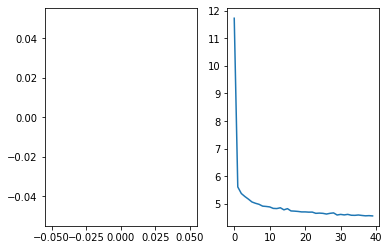

In [185]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
axs[0].plot([x for x in range(len(mean_loss["CNNIL_1"]))],mean_loss["CNNIL_1"])
axs[1].plot([x for x in range(len(mean_loss["CNNIL_2"]))],mean_loss["CNNIL_2"])

## Testing Model

In [195]:
# Generate testing data for both axes
sr_test_1 = SrGen('../data/CNNIL_nifti/Raw_test/','../data/CNNIL_nifti/HR_test_1/','../data/CNNIL_nifti/LR_test_1/')

temp = sr_test_1.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [2,2,1]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
temp['keep_blank'] = False
temp['same_size'] = False
temp['patch'] = [14,14,1] #[x,y,z] when looking at the brain from the top down
temp['step'] = [12,12,4]
sr_test_1.set_template(temp)

#sr_test_1.run(clear=True, save=True)
sr_test_1.match_altered(update=True, paths=False, sort=False)


sr_test_2 = SrGen('../data/CNNIL_nifti/Raw_test/','../data/CNNIL_nifti/HR_test_2/','../data/CNNIL_nifti/LR_test_2/')
temp = sr_test_2.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [1,1,2]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
# temp['scale']= [1,1,1]
temp['keep_blank'] = False
temp['same_size'] = False
temp['patch'] = [1,7,14] #[x,y,z] when looking at the brain from the top down
temp['step'] = [4,6,12]
sr_test_2.set_template(temp)

#sr_test_2.run(clear=True, save=True)
sr_test_2.match_altered(update=True, paths=False, sort=False)


HR and LR file locations updated
HR and LR file locations updated


In [196]:
params_t = {'batch_size': 1,
        'shuffle': False,
        'num_workers': 2}

testing_set_1 = Dataset(sr_test_1, axs = 'hw')
testing_generator_1 = torch.utils.data.DataLoader(testing_set_1, **params_t)


testing_set_2 = Dataset(sr_test_2, axs = 'w')
testing_generator_2 = torch.utils.data.DataLoader(testing_set_2, **params_t)

#### Run both datasets through the model


In [197]:
from skimage.transform import resize
# Load trained models:
net_1.load_state_dict(torch.load('CNNIL_save_network1_39.p'))


with torch.no_grad():
    comp={'psnr' : [], 'rmse' : []}
    for idx, [im_l, im_h] in enumerate(testing_generator_1):

        # Take low resolution and upscale using bicubic interpolation
        # (which has already been done due to the image generation process)
        # Thus im_l is the bicubic interpolation to compare to...

        # Use SR model on low resolution image
        output_1, output_2 = net_1(im_l)

        # Upscale im_l to the same size as im_h
        im_l = torch.tensor(resize(im_l, im_h.shape, order=1, mode = 'symmetric'))

        # Calculate PSNR for bicubic
        # im_l = np.rint( np.clip(im_l, 0, 255))
        # im_h = np.rint( np.clip(im_h, 0, 255))
        diff = im_l - im_h
        rmse_b = np.sqrt((diff**2).mean())
        psnr_b = 20*np.log10(im_h.max()/rmse_b)

        #print(f'bicubic evaluation for {idx}: rms={rmse_b}, psnr={psnr_b}')

        # Calculate PSNR for SR
        # im_h_sr = np.rint( np.clip(im_h_sr, 0, 255))
        # im_h = np.rint( np.clip(im_h, 0, 255))
        diff = output_2 - im_h
        rmse_s = np.sqrt((diff**2).mean())
        psnr_s = 20*np.log10(im_h.max()/rmse_s)
        #print(f'SR evaluation for {idx}: rms={rmse_s}, psnr={psnr_s}')
        if idx % 50 == 0:
            comp['psnr'].append(psnr_s-psnr_b)
            comp['rmse'].append(rmse_s-rmse_b)


Text(0.5, 1.0, 'RMSE: SR - BiC')

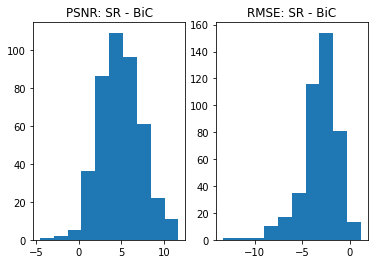

In [198]:
# Sanity check, plot a histogram of how well the SR image performed compared to the Bicubic comparison
fig, axs = plt.subplots(1, 2)
axs[0].hist([float(x) for x in comp['psnr']], bins=10)
axs[0].set_title('PSNR: SR - BiC')
axs[1].hist([float(x) for x in comp['rmse']], bins=10)
axs[1].set_title('RMSE: SR - BiC')

In [199]:
# Load trained models:
net_2.load_state_dict(torch.load('CNNIL_save_network2_39.p'))


with torch.no_grad():
    comp={'psnr' : [], 'rmse' : []}
    for idx, [im_l, im_h] in enumerate(testing_generator_2):

        # Use SR model on low resolution image
        output_1, output_2 = net_2(im_l)

        # Upscale im_l to the same size as im_h
        im_l = torch.tensor(resize(im_l, im_h.shape, order=1, mode = 'symmetric'))

        # Calculate PSNR for bicubic
        # im_l = np.rint( np.clip(im_l, 0, 255))
        # im_h = np.rint( np.clip(im_h, 0, 255))
        diff = im_l - im_h
        rmse_b = np.sqrt((diff**2).mean())
        psnr_b = 20*np.log10(im_h.max()/rmse_b)

        #print(f'bicubic evaluation for {idx}: rms={rmse_b}, psnr={psnr_b}')

        # Calculate PSNR for SR
        # im_h_sr = np.rint( np.clip(im_h_sr, 0, 255))
        # im_h = np.rint( np.clip(im_h, 0, 255))
        diff = output_2 - im_h
        rmse_s = np.sqrt((diff**2).mean())
        psnr_s = 20*np.log10(im_h.max()/rmse_s)
        #print(f'SR evaluation for {idx}: rms={rmse_s}, psnr={psnr_s}')
        if idx % 50 == 0:
            comp['psnr'].append(psnr_s-psnr_b)
            comp['rmse'].append(rmse_s-rmse_b)


Text(0.5, 1.0, 'RMSE: SR - BiC')

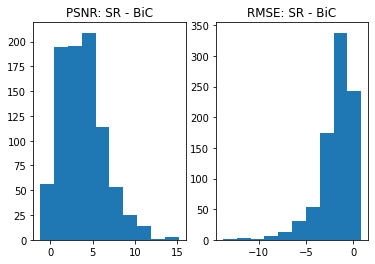

In [200]:
# Sanity check, plot a histogram of how well the SR image performed compared to the Bicubic comparison
fig, axs = plt.subplots(1, 2)
axs[0].hist([float(x) for x in comp['psnr']], bins=10)
axs[0].set_title('PSNR: SR - BiC')
axs[1].hist([float(x) for x in comp['rmse']], bins=10)
axs[1].set_title('RMSE: SR - BiC')

# Final Application

This is where I test both models on a full MRI image and see how it performs

- [X] Create dataset of slightly altered full MRI `.nii` files
- [X] Load saved trained models
- [ ] Compare to simple binomial interpolation (PSNR)


In [201]:
# Generate testing data for both axes
sr = SrGen('../data/CNNIL_nifti/Raw_test/','../data/CNNIL_nifti/Full_test/','../data/CNNIL_nifti/LR_Full_test/')

temp = sr.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [2,2,2]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
temp['keep_blank'] = False
temp['same_size'] = False

sr.set_template(temp)

#sr.run(clear=True, save=True)
sr.match_altered(update=True, paths=False, sort=False)

HR and LR file locations updated


In [208]:
# Run on full image:
# Load matched images
im_hr, im_lr = sr.match_altered(update = True, paths=True)

# Load trained models:
net_1.load_state_dict(torch.load('CNNIL_save_network1_39.p'))
net_2.load_state_dict(torch.load('CNNIL_save_network2_39.p'))

with torch.no_grad():
    old_img = sr.load_image(im_lr[1])
    print(im_lr[1])
    dim = old_img.shape
    print(dim)

    new_img = np.zeros(dim)

    #print(torch.unsqueeze(torch.transpose(torch.tensor(old_img,dtype=torch.float32),2,0),1).shape)
    output_1, output_2 = net_1(torch.unsqueeze(torch.tensor(old_img,dtype=torch.float32),1))#(torch.unsqueeze(torch.transpose(torch.tensor(old_img,dtype=torch.float32),2,0),1))
    #sr.save_image('something.nii', torch.squeeze(output_2,1).numpy())
    
    
    # print(output_2.shape)
    output_1, output_2 = net_2(torch.transpose(output_2,0,3))
    print(output_2.shape)
    # print(torch.transpose(torch.transpose(torch.squeeze(output_2,1),0,1),1,2).shape)
    sr.save_image('something.nii', torch.transpose(torch.squeeze(output_2,1),2,0).numpy())


# for i in range(dim[2]):
    # net_1(torch.unsqueeze(torch.tensor(old_img[:,:,i]),0))



HR and LR file locations updated
../data/CNNIL_nifti/LR_Full_test/29014_anat_rot0_0_0_tr0_0_0_scale_1_1_1.nii
(96, 128, 128)
torch.Size([256, 1, 256, 192])


../data/CNNIL_nifti/LR_Full_test/29014_anat_rot0_0_0_tr0_0_0_scale_1_1_1.nii
../data/CNNIL_nifti/Full_test/29014_anat_rot0_0_0_tr0_0_0_scale_1_1_1.nii
(96, 128, 128)
torch.Size([256, 1, 256, 192])


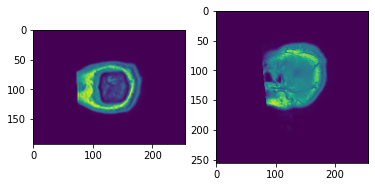

In [209]:
import matplotlib.pyplot as plt

print(im_lr[1])
print(im_hr[1])
print(sr.load_image(im_lr[1]).shape)
print(output_2.shape)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(torch.squeeze(torch.transpose(torch.transpose(torch.squeeze(output_2,1),0,1),1,2)[30,:,:],0))
axs[1].imshow(sr.load_image(im_hr[1])[30,:,:])

In [70]:
sr.save_image('something.nii', torch.squeeze(output_2,1).numpy())

In [ ]:

# with torch.no_grad():
#     comp={'psnr' : [], 'rmse' : []}
#     for idx, [im_l, im_h] in enumerate(testing_generator_2):

#         # Use SR model on low resolution image
#         output_1, output_2 = net_2(im_l)

#         # Upscale im_l to the same size as im_h
#         im_l = torch.tensor(resize(im_l, im_h.shape, order=1, mode = 'symmetric'))

#         # Calculate PSNR for bicubic
#         diff = im_l - im_h
#         rmse_b = np.sqrt((diff**2).mean())
#         psnr_b = 20*np.log10(im_h.max()/rmse_b)

#         #print(f'bicubic evaluation for {idx}: rms={rmse_b}, psnr={psnr_b}')

#         # Calculate PSNR for SR
#         diff = output_2 - im_h
#         rmse_s = np.sqrt((diff**2).mean())
#         psnr_s = 20*np.log10(im_h.max()/rmse_s)
#         #print(f'SR evaluation for {idx}: rms={rmse_s}, psnr={psnr_s}')
#         if idx % 50 == 0:
#             comp['psnr'].append(psnr_s-psnr_b)
#             comp['rmse'].append(rmse_s-rmse_b)

#         # if save_pred:
#         #     img_name = os.path.splitext(os.path.basename(i))[0]
#         #     Image.fromarray(np.rint(im_h_sr).astype(np.uint8)).save(f"{save_dir}/{img_name}_SR.png")
